# CS109 Final Project: Predicting Offensive Playcalling in the NFL


## By Matt Goldberg, Adam Gilfix, Nathaniel Ver Steeg and Steven Rachesky


![Image of NFL](images/nfl_shield.png)

Imagine you are a Defensive Coordinator in the NFL. You'll likely find yourself in control of the defensive play-calling decisions, a difficult task especially with limited knowledge of the opponent's offensive tendencies or more specifically the exact play the offense will execute. Let's take Rob Ryan as an example (pictured below):


![Image of NFL](images/rob_ryan.jpg)


Rob began his NFL career as the Defensive Coordinator of the Oakland Raiders and more recently was fired as the Defensive Coordinator of the New Orleans Saints in the 2015 season. According to this [New York Times article](http://www.nytimes.com/2015/11/18/sports/football/rob-ryan-fired-by-saints-as-defense-struggles.html?_r=0), `"Among the 18 coaches who have been defensive coordinators for at least 10 seasons since 1990, Ryan’s defenses have allowed more points per game and more yards per game to opponents than any other."` It's clear that Ryan could have benefited from better play-calling decisions. In this project, we analyze all pass and run plays in the NFL from the 2003-2014 seasons and generate seven classifiers to predict whether the offense will run or pass. Hopefully Rob Ryan considers some of our best classifiers before he takes his [next job](http://profootballtalk.nbcsports.com/2015/12/09/rob-ryan-spotted-at-bills-practice-in-team-gear/) as a Defensive Coordinator, possibly with the Buffalo Bills under his brother, Rex Ryan. 

## Table of Contents
* [1. Scraping](https://github.com/mdgoldberg/cs109finalproject/blob/master/Scraping.ipynb)
* [2. Data Cleaning](https://github.com/mdgoldberg/cs109finalproject/blob/master/proj.ipynb)
* [3. Exploratory Data Analysis (EDA)](https://github.com/mdgoldberg/cs109finalproject/blob/master/Some%20EDA.ipynb)
* [4. Model Development and Findings](https://github.com/mdgoldberg/cs109finalproject/blob/master/proj_func.ipynb)
* [5. Future Work and Conclusions]()

Note: Please find our project [website](https://mdgoldberg.github.io/cs109finalproject) and [video](https://www.youtube.com/watch?v=K1dF9cIwiIE) linked. 

In [1]:
#Imports
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

We first load our data into `completedf` and are careful to remove the 2002 year. This year was only included so that we can calculate our lag features such as `tm_prev_yr_pass` for the 2003 season.

In [2]:
# upload all data to have as one dataset again
completedf1 = pd.concat([pd.read_csv('0204plays.csv'),pd.read_csv('0507plays.csv'),pd.read_csv('0810plays.csv'),pd.read_csv('1114plays.csv')])

#(remove 2002, because it has served it's purpose of creating 2003 priors)
completedf = completedf1[completedf1['year']>2002].reset_index(drop=True)

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (63,102) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


## 1. Scraping


In order to perform our analysis, we needed to scrape data on every NFL play from the 2002-2014 seasons. Although our analysis is based on the 2003-2014 seasons, we included the 2002 season in order to create lag features in our DataFrame such as each team's previous year pass percentage. We acquired this data from [Pro-Football Reference's](http://www.pro-football-reference.com) play-by-play account of each game using Matt Goldberg's pfr library. *Please refer to our [**Scraping Notebook**](https://github.com/mdgoldberg/cs109finalproject/blob/master/Scraping.ipynb) in order to view our exact process and scripts used in acquring the data.* This process resulted in a large DataFrame of about 450,000 plays and 115 raw features describing these plays. Some of the features we acquired in this stage are which quarter it is, how much time left in the game, the scores of the teams, and, of course, whether the play was a run, a pass, or some other type of play like a field goal, punt, or kickoff (these plays would later be discarded from the training set). However, we realized we needed to infer more specific features in order to complete our analysis. We  abstracted these latter features and discuss difficulties in the accuracy and cleaning of Pro-Football Reference's recount of each game in our [**Data Cleaning**](https://github.com/mdgoldberg/cs109finalproject/blob/master/proj.ipynb) section. 

## 2. Data Cleaning


Upon scraping our initial CSVs, one for each year’s worth of plays in the NFL, it was necessary to merge them and explore the data’s tendencies, find errors from the scraped site, deal with those errors, make some other cleaning adjustments, and create other columns that would be useful for modeling.  Part of the error avoidance and cleaning process involved removing rows from our dataset that were two-point conversions or were neither pass nor run plays, as well as removing plays where values like the team with the ball or expected points was missing.  Some of the cleaning/column creation that we did after merging included making an indicator for if the team with the ball was the home team and then using several columns that were defined in terms of the home and away team to create those same columns with respect to the team with the ball and that team’s opponent.  This was very important in that it enabled us to create many more feature columns describing the team’s (with the ball) passing tendencies (previous season passing percentage, current season passing percentage) and game-related variables (in game passing percentage, timeouts remaining in the half, margin) that we later used in modeling. A full breakdown of our cleaning process is available on our [Data Cleaning Notebook](https://github.com/mdgoldberg/cs109finalproject/blob/master/proj.ipynb) titled `proj.ipynb`. 

## 3. Exploratory Data Analysis (EDA)


In this section, we explore numerous relationships amongst our data. We begin by introducing a simple way of viewing a certain distribution of football plays through our football field visualizations. These visualizations aid in displaying the numerous possible classifications a play can recieve. We then proceed by exploring the evolution of pass percentage over the course of the 2003 through 2014 seasons both on a team and by analyzing the fundamental and unintuitive relationships between our predictor variable, `isPass`, and our features. We found that variables such as `yds_to_go` and `inDown3` separated pass and run plays the best. To conclude our EDA, we studied not only how run and pass plays progress throughout the game but also how passing frequency changes with the `down` and `yds_to_go` variables. *Please refer to our [**EDA Notebook**](https://github.com/mdgoldberg/cs109finalproject/blob/master/Some%20EDA.ipynb) in order to view our exact process, scripts and visualizations used in exploring our data.*

## 4. Model Development and Findings


After completing our EDA section, we used some of our feature selection techniques and our general intuition about football offenses to model seven classifiers -- Linear SVM, SVC, Logistic Regression with Lasso, Logistic Regression with Ridge, ADA Boost and Gradient Boost -- to predict whether the offense's play will be a run or pass. Alongside some of these classifiers we also display the most important features they used as well as decision surface meshgrids to display their accuracy. Our complete Model Development and Findings section is available in our [Analysis Notebook](https://github.com/mdgoldberg/cs109finalproject/blob/master/proj_func.ipynb) titled `proj_func.ipynb`. It's evident that after training these classifiers, we note that the Gradient Boost ensemble method performed the best reporting an accuracy of 70.3% on our test data for the 2014 NFL Season. This result is very pleasing since it seems reliable enough to not only complement but perhaps rival the intuition of a defensive coordinator like Rob Ryan.

## 5. Future Work and Conclusions


The obvious application of our work is trivial: implementing a software based on our models that can accurately predict whether the offense will run or pass on their next play so that coordinators like Rob Ryan do not lose their job as often (he's been fired 5 times as a defensive coordinator in the NFL). It's feasible to imagine Rob using this software on the sideline so he can complement his football intuition with our predictions. In this scenario, we believe our models will help defensive coordinators predict offensive pass plays significantly. However, its obvious that there are a few limitations with our work. 


The first one that comes to mind is the lack of direction in our classifiers predictions. Remember those nice football visualizations:


![Image of NFL play distribution](images/2003-2014_Football_Play_Distribution_1.png)


Well, it'd be nice to know where our offense will throw or run not just that it will run or throw. Incorporating this detail into our project represents an obvious extension to our model. Our datasets provide the necessary information -- `passLoc` and `rushDir` features that specify whether a pass is deep, short, left, right or middle and which hole in the offensive line the running back attacks -- to abstract these predictions. In fact we used these features to create the above visualization. 

Furthermore, in our *Analysis* section we ran (no pun intended) these classifiers only on a subset of our DataFrame, the 2014 NFL season. Training these classifiers on our larger DataFrame, which encompasses all pass and run plays from 2003 to 2014 NFL seasons, would likely result in an increased accuracy on our test data set. We'd then be able to ensure that Rob Ryan does not get fired from his [next possible job](http://profootballtalk.nbcsports.com/2015/12/09/rob-ryan-spotted-at-bills-practice-in-team-gear/) as Defensive Coordinator of the Buffalo Bills! 

As demonstrated in our football field visualizations, our data is incredibly extensive and can be used to explore other relationships in the NFL. In our *Scraping* section, we specified that we compiled every single play from 2003-2014, but for our classifiers we only needed to use the subset of these that are pass or run plays. For instance, it could be interesting to explore the progression of penalties throughout a game in the NFL:

In [7]:
#clean function for penalty
def clean_penalty(data11):
    data2 = data11[["isPenalty", "qtr_time_remain", "quarter", "secsElapsedInGame"]]
    data2 = data2[data2.quarter != 5.0]
    data2 = data2.dropna()
    data2 = data2[data2["isPenalty"] == True]
    return data2

#plot function for penalty in game
def plot_penalty(data):
    ax = plt.subplot(111)
    ax.hist(data["secsElapsedInGame"].values, bins=20, color="lightgreen", alpha=0.8)
    ax.set_title("Penalty Progression")
    ax.set_xlabel("Time elapsed (seconds)")
    ax.set_ylabel("Frequency")
    ax.set_xlim(0,3600)
    ax.axvline(15*60, color="k", label = "quarter end", ls = '--')
    ax.axvline(30*60, color="k", ls = '--')
    ax.axvline(45*60, color="k", ls = '--')
    ax.legend()
    ax.grid(False)
    sns.despine()
    return ax

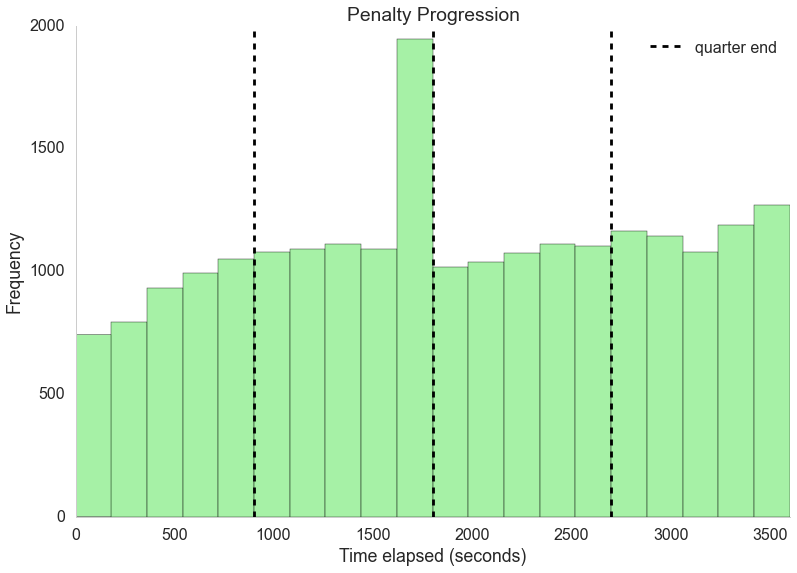

In [8]:
#run penalty code 
dfcp = clean_penalty(completedf)
plot_penalty(dfcp)

This penalty chart is based on game data from the 2003-2014 seasons. It's evident that there is a general, positive trend in the occurrence of penalties throughout a given NFL game and a *massive* spike in the frequency of penalties right before halftime. This spike is likely due to the teams taking "boom or bust" plays or are acting out of desperation to try to score before the conclusion of the first half. It's likely that there isn't as big of a spike at the conclusion of the second half since games are sometimes decided by that point. The general positive trend in penalties can also likely be explained by this theory of teams running more desperate plays or even referees just simply noticing more penalties since the later stage of the game may matter more in determining which team wins. Another possible theory is that as players fatigue over the course of a half, their discipline and focus let up a bit and they may make more mental mistakes. More analysis can be performed on this topic to correctly explain the trend observed in the above plot. Another interesting area of exploration that our DataFrame provides is studying the reward of a certain play at a given time in the game. Below we display a histogram of the expected points differential (`exp_pts_after` - `exp_pts_before`) for both pass and run plays.

In [18]:
# clean dataframe for expected points plot
def clean_exp(completedf):
    dfexp = completedf[['exp_pts_after', 'exp_pts_before', "isPass", "isRun", "secsElapsedInGame"]]
    dfexp["diff_exp"] = dfexp["exp_pts_after"] - dfexp["exp_pts_before"]
    dfexp = dfexp.dropna()
    return dfexp
   
# function for plotting the expected points difference    
def plot_exp(data):
    ax = plt.subplot(111)
    ax.hist(data["diff_exp"].values, bins=40, color="m", alpha=0.3, label = "Expected Points Differential")
    ax.hist(data[data["isPass"] == True]["diff_exp"].values, bins=40, color="b", alpha=0.5, label = "Pass Expected Points Differential")
    ax.hist(data[data["isRun"] == True]["diff_exp"].values, bins=40, color="y", alpha=0.5, label = "Run Expected Points Differential")
    ax.set_title("Expected Points Progression")
    ax.set_xlabel("Expected Points")
    ax.set_ylabel("Frequency")
    ax.set_xlim(-7,7)
    ax.legend()
    ax.grid(False)
    sns.despine()
    return ax

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


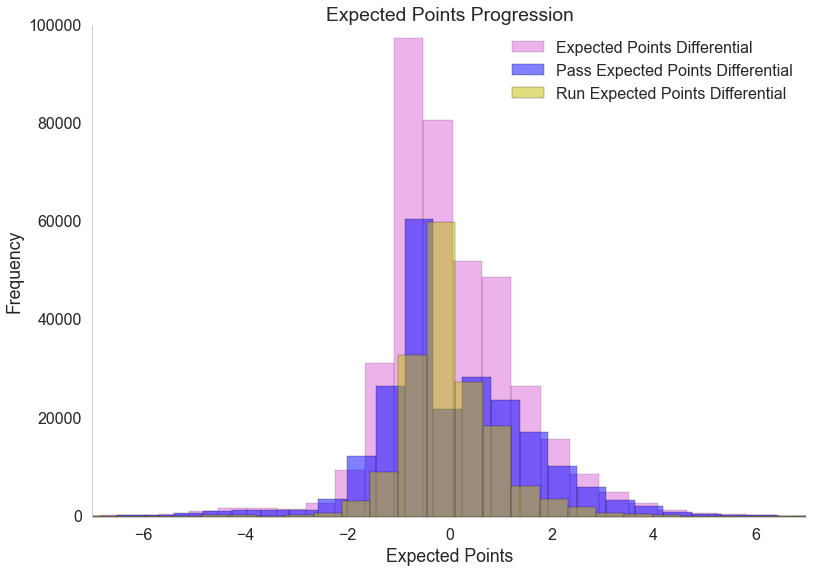

In [19]:
# plots of expected points differential
dfce = clean_exp(completedf)
plot_exp(dfce)

Here, the pink histogram represents overall expected points gained for each play. It's worth noting that common characteristics of all histograms are unimodal and slightly right skewed. In terms of the pink distribution, which is centered around -1 expected points per play, shows that a typical play in the NFL (pass or run) results in very few expected points gained. This signifies that negative outcomes on plays are more common than positive. The breakdown of the run and pass histograms display that runs are actually more conservative than pass plays - an already intuitive and known fact. The skewness of these histograms show that incredibly high reward plays are more common than incredibly high loss plays, however, the center of each histogram shows that the most typical play results in negatie expected points gained. 


These penalty and expected points plots represent introductions to other studies that can be carried out with our data, and it's likely that these studies can help abstract new features to feed into our classifiers. In short, we reported a high of 70.3% accuracy on a test set for our Gradient Boost classifier that predicts a run or pass play and are pleased that our current model can help Rex Ryan become a better Defensive Coordinator. 